In [1]:
import os

import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

            GeoId  Exposure-type  Burn-Probability  \
0     48157674100       0.143601          0.000013   
1     48157674200       0.257008          0.000046   
2     48441013501       0.870203          0.003103   
3     48441013602       0.707624          0.002678   
4     48441013601       0.391720          0.000694   
...           ...            ...               ...   
6878  48061012700       0.515126          0.002880   
6879  48061013203       0.170424          0.000186   
6880  48061012508       0.292111          0.000263   
6881  48061011903       0.223237          0.000195   
6882  48061014002       0.000000          0.000000   

      Risk-2-Potential-Structures  Flame-Length-Over-8-Feet  \
0                        0.000291                  0.000000   
1                        0.000875                  0.000000   
2                        0.123327                  0.024073   
3                        0.113393                  0.031639   
4                        0.027320   

<Axes: >

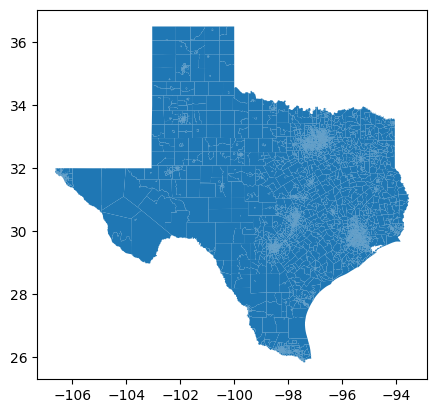

In [13]:
# Path to the GeoJSON file
geojson_file = "C:\\Users\\harma\\OneDrive\\Desktop\\i-guide-summer-school-firerisk\\datasets\\results.geojson"

# Read the GeoJSON file
gdf = gpd.read_file(geojson_file)

# Print the GeoDataFrame
print(gdf)

# Plot the GeoDataFrame
gdf.plot()

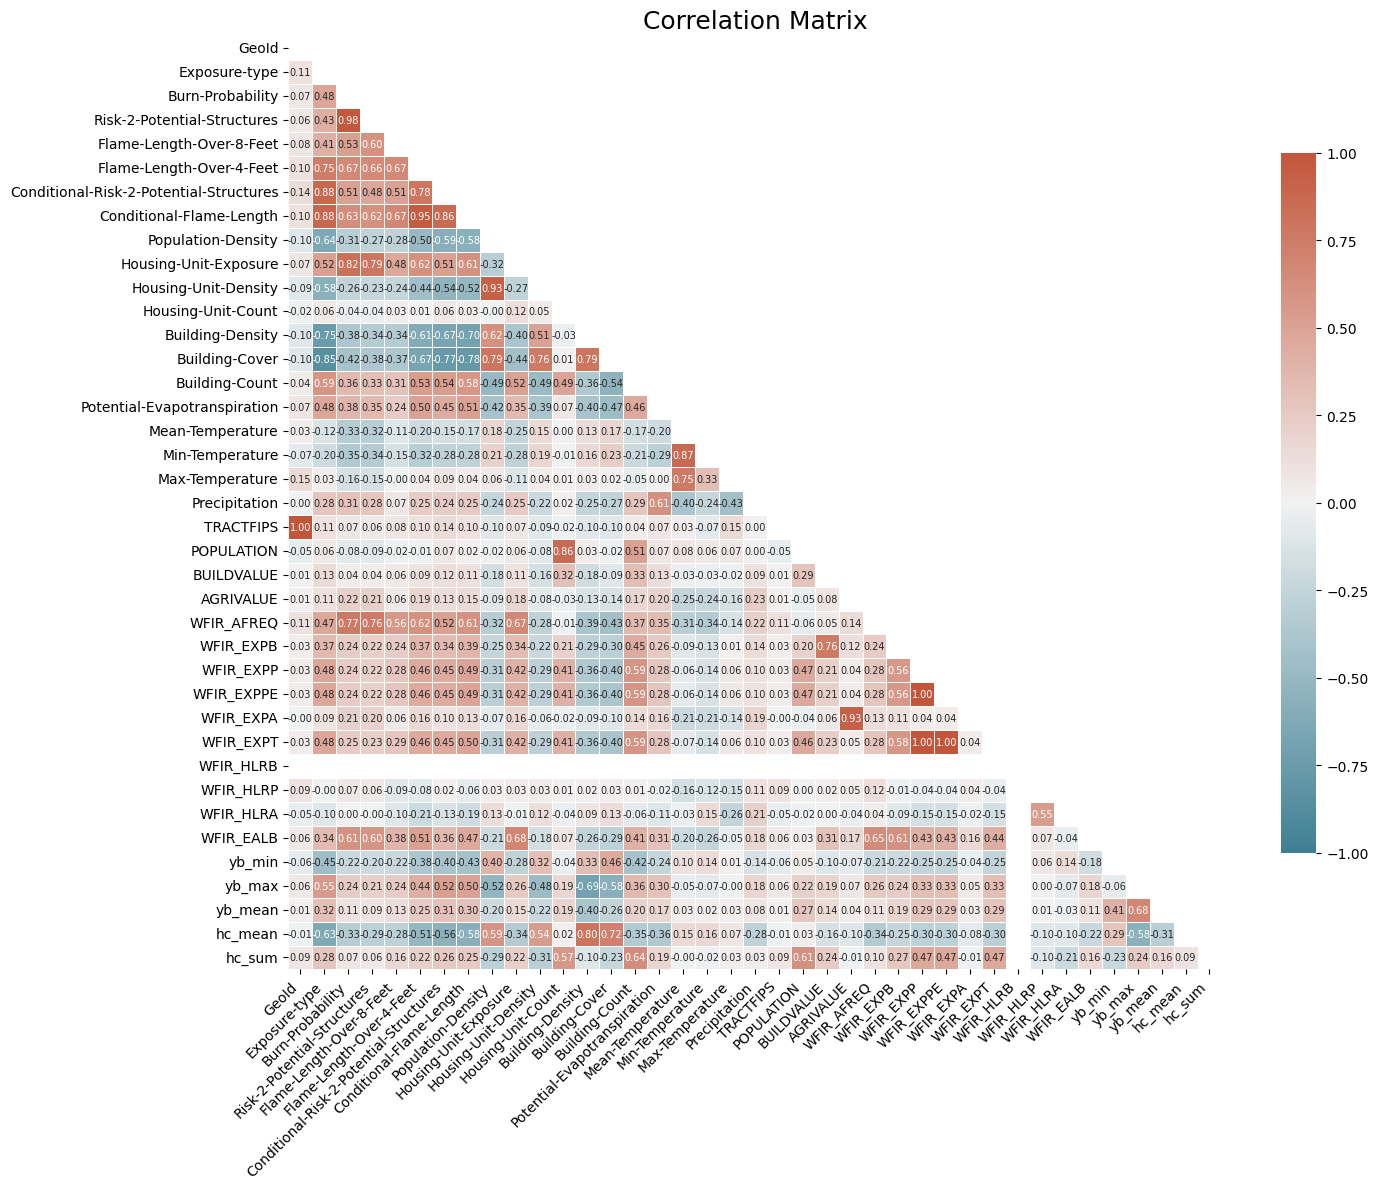

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop geometry column to compute correlation only on attribute data
gdf_attributes = gdf.drop(columns='geometry')

# Select only numeric columns
numeric_columns = gdf_attributes.select_dtypes(include=['number']).columns
gdf_numeric = gdf_attributes[numeric_columns]

# Compute the correlation matrix
correlation_matrix = gdf_numeric.corr()

# Print the correlation matrix
#print("Correlation Matrix:")
#print(correlation_matrix)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f', annot_kws={"size": 7}, square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})

# Add title and adjust layout
plt.title('Correlation Matrix', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

Mean Squared Error: 0.24235210073707292
R^2 Score: 0.8004876298204446


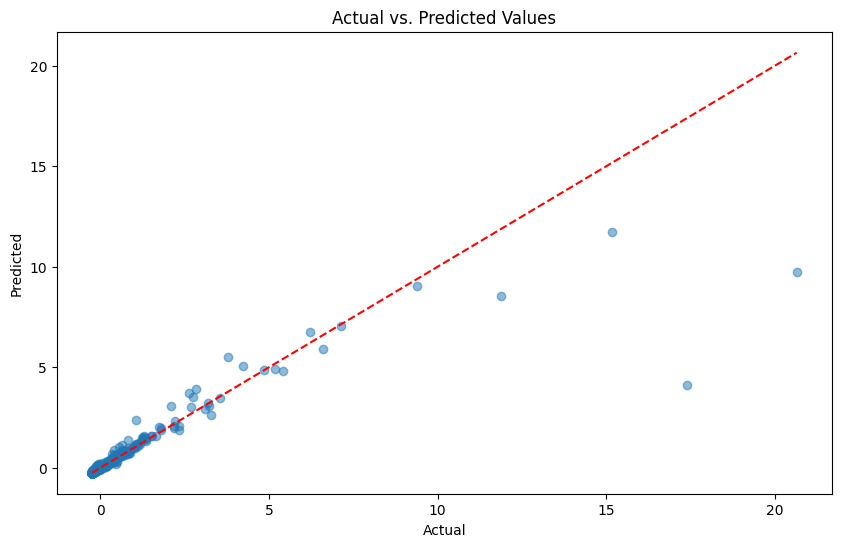

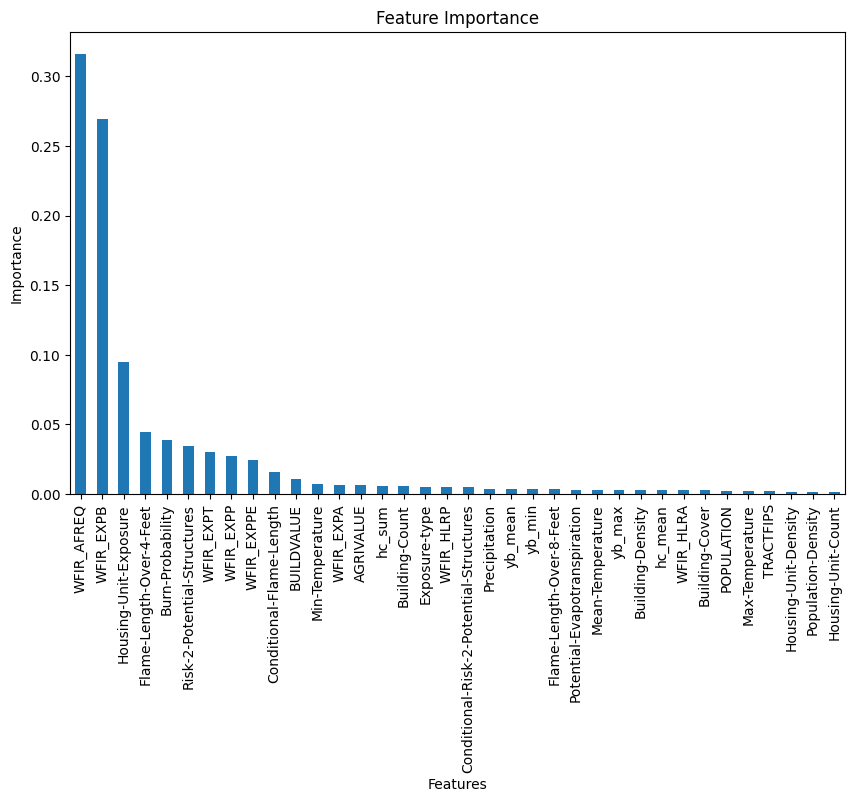

In [12]:
import joblib
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Path to the CSV file (CHANGE FILE PATH)
csv_file = 'datasets/processed/scaled_results.csv'

# Read the CSV file
df = pd.read_csv(csv_file)

# Assume 'target_var' is the dependent variable and the rest are predictors
target_var = 'WFIR_EALB'  

# Ensure the target variable is in the DataFrame
if target_var not in df.columns:
    raise ValueError(f"Target variable '{target_var}' not found in the DataFrame columns.")

# Convert categorical variables to dummy variables (one-hot encoding)
df_dummies = pd.get_dummies(df, drop_first=True)

# Drop columns with all missing values
df_dummies = df_dummies.dropna(axis=1, how='all')

# Separate dependent (target) and independent (predictor) variables
y = df_dummies[target_var]
X = df_dummies.drop(columns=[target_var])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize the Extra Trees Regressor
et = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
et.fit(X_train, y_train)

# Save the model
joblib.dump(et, 'extra_trees_regressor_model.joblib')

# Predict on the test data
y_pred = et.predict(X_test)

# Save the results to a CSV file
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('extra_trees_predictions.csv', index=False)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Feature importance
feature_importances = pd.Series(et.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()